In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow import *
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils.np_utils import to_categorical
import datetime
from keras.callbacks import TensorBoard, ModelCheckpoint
from skopt import callbacks
from skopt.callbacks import CheckpointSaver
from tensorflow.python.client import device_lib
import pandas as pd
import gc
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from skopt.plots import plot_objective_2D
import time
from skopt import load
from keras.applications.efficientnet import preprocess_input
from tensorflow.keras import mixed_precision
import os

In [2]:
### zmiejszoby rozmiar, dla ułatwienia obliczeń (mniejsze zuzycie GPU)

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory('./data/', 
                                                           label_mode = None, image_size = (256, 256), batch_size = 4)
data = data.map(lambda x: x / 255.0)

Found 300 files belonging to 1 classes.


In [4]:
def Generator():
    model = tf.keras.Sequential()
    model.add(Dense(32*32*256,activation="relu",input_dim=256))  #256
    model.add(Reshape((32,32,256)))
    model.add(Conv2D(256,(5,5),padding="same",activation="relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(256,(5,5),padding="same",activation="relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(128,(3,3),padding="same",activation="relu"))
    model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
    model.add(Conv2D(32,(3,3),padding="same",activation="relu"))
    model.add(Conv2D(3,(3,3),padding="same"))
    model.add(Activation("tanh"))
    return model

In [13]:
keras.backend.clear_session()
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 131072)            33685504  
                                                                 
 reshape (Reshape)           (None, 32, 32, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 256)       819456    
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 128, 128, 128)    0         
 2D)                                                    

(-0.5, 127.5, 127.5, -0.5)

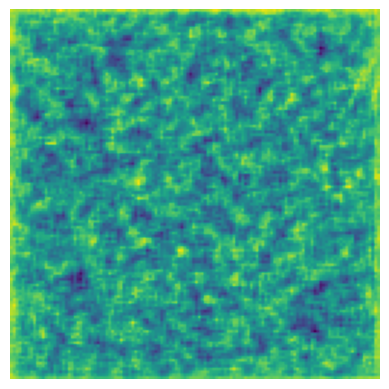

In [15]:
generator = Generator()
#Creating a random seed and output from generator
seed = tf.random.normal([1, 256])
generated_image = generator(seed, training=False)
#Plotting the image output of generator without training 
plt.imshow(generated_image[0, :, :, 0])
plt.axis("off")

In [ ]:
generated_image.shape

In [5]:
def Discrimiator():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, (3,3), strides=(2,2), padding='same',
                                     input_shape=[256,256, 3]))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(GlobalMaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="softmax"))

    return model

In [16]:
keras.backend.clear_session()
discriminator = Discrimiator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 121, 121, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                    

In [6]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):
        super(GAN, self).compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn
        self.discriminator_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.generator_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.discriminator_loss_metric, self.generator_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(seed)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.discriminator_loss_metric.update_state(d_loss)
        self.generator_loss_metric.update_state(g_loss)
        return {"discriminator_loss": self.discriminator_loss_metric.result(), "generator_loss": self.generator_loss_metric.result()}

In [7]:
keras.backend.clear_session()
generator = Generator()
discriminator = Discrimiator()
epochs = 200
model = GAN(discriminator=discriminator, generator=generator, latent_dim=256)

model.compile(tf.keras.optimizers.Adam(1.5e-5,0.5), tf.keras.optimizers.Adam(1.5e-5,0.5), loss_fn=tf.keras.losses.BinaryCrossentropy())

history = model.fit(data, epochs=epochs)

Epoch 1/200
75/75 [==============================] - 47s 358ms/step - discriminator_loss: 0.6475 - generator_loss: 0.6730
Epoch 2/200
75/75 [==============================] - 30s 364ms/step - discriminator_loss: 0.6129 - generator_loss: 0.6916
Epoch 3/200
75/75 [==============================] - 31s 377ms/step - discriminator_loss: 0.6945 - generator_loss: 0.5422
Epoch 4/200
75/75 [==============================] - 30s 365ms/step - discriminator_loss: 0.6848 - generator_loss: 0.6741
Epoch 5/200
75/75 [==============================] - 31s 381ms/step - discriminator_loss: 0.6876 - generator_loss: 0.6551
Epoch 6/200
75/75 [==============================] - 31s 381ms/step - discriminator_loss: 0.6802 - generator_loss: 0.7033
Epoch 7/200
75/75 [==============================] - 31s 384ms/step - discriminator_loss: 0.6913 - generator_loss: 0.6966
Epoch 8/200
75/75 [==============================] - 29s 362ms/step - discriminator_loss: 0.6802 - generator_loss: 0.7428
Epoch 9/200
75/75 [=====

75/75 [==============================] - 29s 346ms/step - discriminator_loss: 0.6935 - generator_loss: 0.6991
Epoch 68/200
75/75 [==============================] - 28s 336ms/step - discriminator_loss: 0.6944 - generator_loss: 0.6975
Epoch 69/200
75/75 [==============================] - 28s 343ms/step - discriminator_loss: 0.6937 - generator_loss: 0.6975
Epoch 70/200
75/75 [==============================] - 29s 344ms/step - discriminator_loss: 0.6931 - generator_loss: 0.6955
Epoch 71/200
75/75 [==============================] - 29s 346ms/step - discriminator_loss: 0.6939 - generator_loss: 0.6855
Epoch 72/200
75/75 [==============================] - 29s 341ms/step - discriminator_loss: 0.6940 - generator_loss: 0.6929
Epoch 73/200
75/75 [==============================] - 29s 347ms/step - discriminator_loss: 0.6946 - generator_loss: 0.6930
Epoch 74/200
75/75 [==============================] - 29s 345ms/step - discriminator_loss: 0.6939 - generator_loss: 0.6926
Epoch 75/200
75/75 [=========

75/75 [==============================] - 29s 340ms/step - discriminator_loss: 0.6926 - generator_loss: 0.7047
Epoch 134/200
75/75 [==============================] - 29s 347ms/step - discriminator_loss: 0.6935 - generator_loss: 0.6901
Epoch 135/200
75/75 [==============================] - 29s 340ms/step - discriminator_loss: 0.6940 - generator_loss: 0.6957
Epoch 136/200
75/75 [==============================] - 28s 335ms/step - discriminator_loss: 0.6934 - generator_loss: 0.6952
Epoch 137/200
75/75 [==============================] - 29s 341ms/step - discriminator_loss: 0.6934 - generator_loss: 0.6855
Epoch 138/200
75/75 [==============================] - 28s 338ms/step - discriminator_loss: 0.6938 - generator_loss: 0.6879
Epoch 139/200
75/75 [==============================] - 29s 342ms/step - discriminator_loss: 0.6947 - generator_loss: 0.6883
Epoch 140/200
75/75 [==============================] - 28s 338ms/step - discriminator_loss: 0.6931 - generator_loss: 0.6905
Epoch 141/200
75/75 [=

75/75 [==============================] - 28s 336ms/step - discriminator_loss: 0.6932 - generator_loss: 0.6950
Epoch 200/200
75/75 [==============================] - 29s 342ms/step - discriminator_loss: 0.6942 - generator_loss: 0.6928


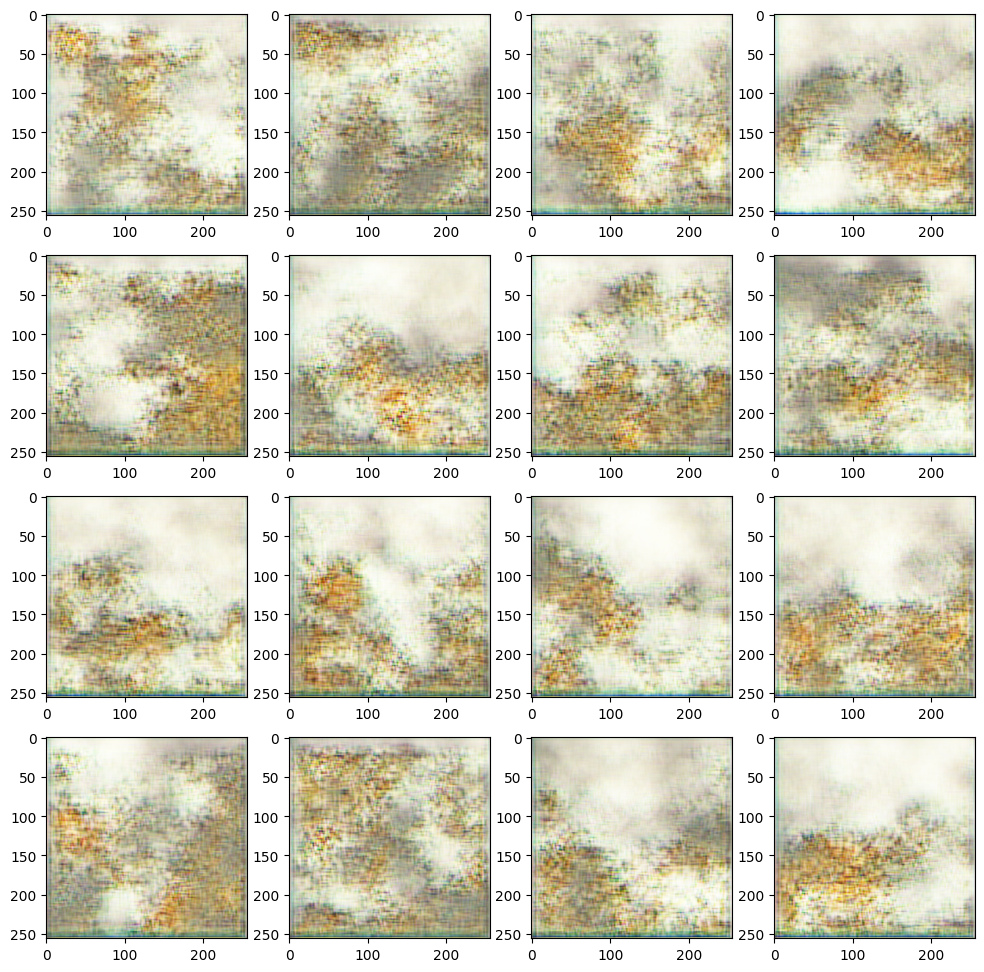

In [8]:
generated_images = []
for i in range(0, 16):
    seed = tf.random.normal([1, 256])
    generated_image = generator(seed, training=False)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    img = tf.keras.preprocessing.image.array_to_img(generated_image[0])
    generated_images.append(img)
    
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(generated_images, axs):
    ax.imshow(img)
